In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [19]:
excel_path = "mouse_data.xlsx"
ACT_SHEET  = "Fem Act"
TEMP_SHEET = "Fem Temp"
BIN_SIZE = 30 

In [20]:
xls = pd.ExcelFile(excel_path)
act_df = pd.read_excel(xls, sheet_name = ACT_SHEET)
tmp_df = pd.read_excel(xls, sheet_name = TEMP_SHEET)

In [21]:
for df in (act_df, tmp_df):
    df["day"]    = df.index // 1440
    df["minute"] = df.index % 1440
    df["estrus"] = (df["day"] % 4 == 2)

In [22]:
mouse_cols = [
    c for c in act_df.columns if c not in ("day", "minute", "estrus")
]

act_long = act_df.melt(
    id_vars = ["day", "minute", "estrus"],
    value_vars = mouse_cols,
    var_name = "mouse",
    value_name = "activity"
)

tmp_long = tmp_df.melt(
    id_vars = ["day", "minute", "estrus"],
    value_vars = mouse_cols,
    var_name = "mouse",
    value_name = "temperature"
)

In [23]:
df = pd.merge(act_long, tmp_long, on=["day","minute","estrus","mouse"])
df["hour"] = df["minute"] // BIN_SIZE

summary = (
    df
    .groupby(["estrus","hour"])
    .agg(
      activity_mean    = ("activity",    "mean"),
      activity_std     = ("activity",    "std"),
      activity_count   = ("activity",    "count"),
      temperature_mean = ("temperature", "mean"),
      temperature_std  = ("temperature", "std"),
      temperature_count= ("temperature", "count")
    )
    .reset_index()
)

In [24]:
with open("../data/summary_phase1.json","w") as f:
    json.dump(summary.to_dict(orient="records"), f, indent=2)

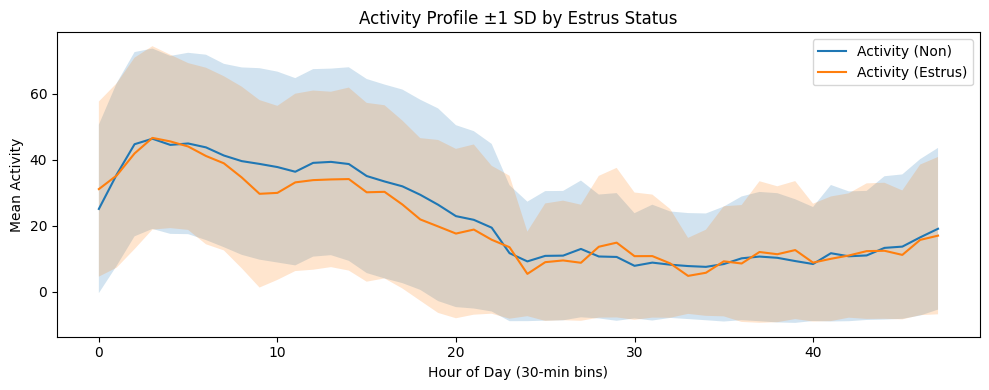

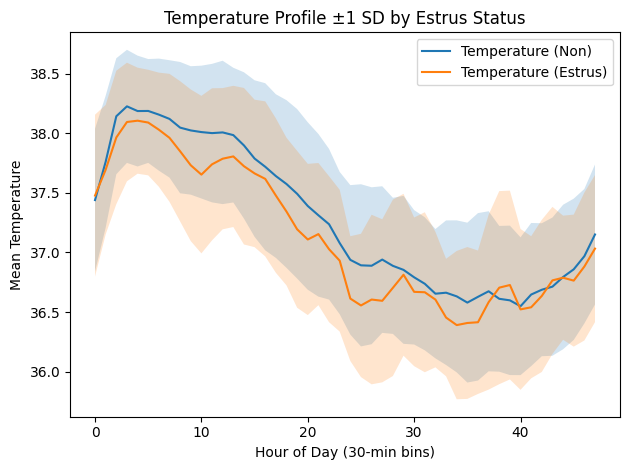

In [25]:
plt.figure(figsize=(10,4))

for metric in ["activity","temperature"]:
    ax = plt.gca()
    
    for estrus_flag, grp in summary.groupby("estrus"):
        label = f"{metric.title()} ({'Estrus' if estrus_flag else 'Non'})"
        x = grp["hour"]
        y = grp[f"{metric}_mean"]
        sd = grp[f"{metric}_std"]
        ax.plot(x, y, label=label)
        ax.fill_between(x, y - sd, y + sd, alpha=0.2)
        
    ax.set_xlabel(f"Hour of Day ({BIN_SIZE}-min bins)")
    ax.set_ylabel(f"Mean {metric.title()}")
    ax.set_title(f"{metric.title()} Profile ±1 SD by Estrus Status")
    ax.legend()
    plt.tight_layout()
    plt.show()

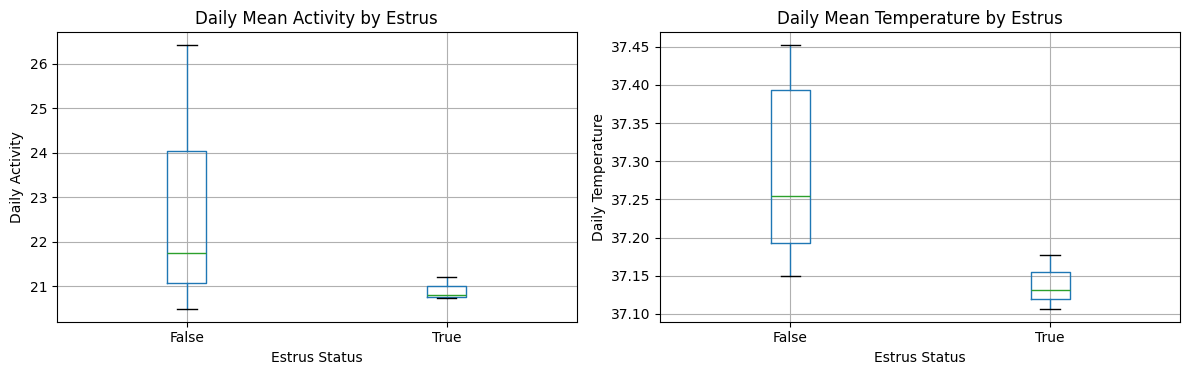

In [26]:
daily = (
    df
    .groupby(["day","estrus"])
    .agg(
      daily_activity    = ("activity",    "mean"),
      daily_temperature = ("temperature", "mean")
    )
    .reset_index()
)

fig, axes = plt.subplots(1,2, figsize=(12,4))
daily.boxplot(column="daily_activity", by="estrus", ax=axes[0])
axes[0].set_title("Daily Mean Activity by Estrus")
axes[0].set_xlabel("Estrus Status")
axes[0].set_ylabel("Daily Activity")

daily.boxplot(column="daily_temperature", by="estrus", ax=axes[1])
axes[1].set_title("Daily Mean Temperature by Estrus")
axes[1].set_xlabel("Estrus Status")
axes[1].set_ylabel("Daily Temperature")

plt.suptitle("")
plt.tight_layout()
plt.show()